## Generate images from pretrained StyleGAN2 models

In [17]:
from easydict import EasyDict
from model import Generator
import torch
from PIL import Image
from IPython.display import display

/home/zhanghm/Research/StyleGAN/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.6.0. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


torch.Size([2, 3, 1024, 1024]) tensor(-1.3339, device='cuda:0') tensor(1.3171, device='cuda:0')


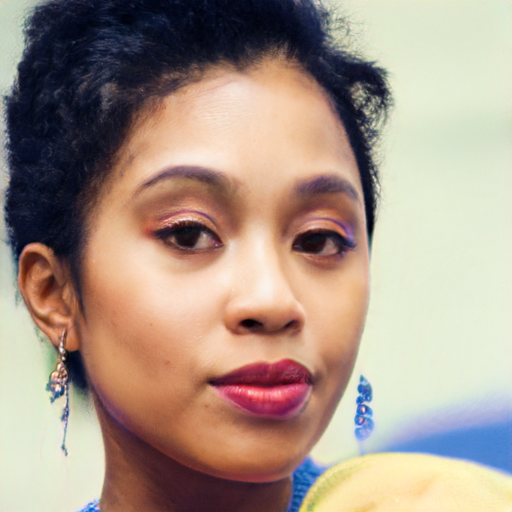

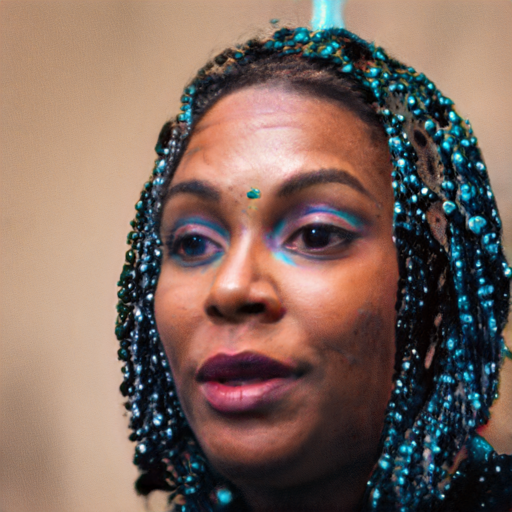

In [40]:
def convert2img(sample, range=(-1, 1)):
    """Convert the tensor from StyleGAN network output to [0, 255] image

    Args:
        sample (_type_): _description_
    Returns:
        (B, 3, H, W)
    """
    def norm_ip(img, min, max):
        img.clamp_(min=min, max=max)
        img.add_(-min).div_(max - min + 1e-5)

    def norm_range(t, range):
        if range is not None:
            norm_ip(t, range[0], range[1])
        else:
            norm_ip(t, float(t.min()), float(t.max()))

    gen_image = sample.clone()
    norm_range(gen_image, range)

    output = gen_image.mul_(255).add_(0.5).clamp_(0, 255)
    return output


ckpt_path = "/home/zhanghm/Research/StyleGAN/pixel2style2pixel/pretrained_models/stylegan2-ffhq-config-f.pt"

device = "cuda:0"

args = EasyDict(ckpt=ckpt_path,
                size=1024, latent=512, n_mlp=8, 
                channel_multiplier=2, truncation=1)

## Load the model
g_ema = Generator(
        args.size, args.latent, args.n_mlp, channel_multiplier=args.channel_multiplier
    ).to(device)
checkpoint = torch.load(args.ckpt)
g_ema.load_state_dict(checkpoint["g_ema"])

## Generate the image
with torch.no_grad():
    g_ema.eval()
    sample_z = torch.randn(1, 512, device=device)
    dummy = torch.randn(1, 512, device=device)
    # sample_z2 = sample_z + 0.15
    sample_z2 = sample_z + dummy
    sample_z = torch.cat([sample_z, sample_z2], dim=0)

    sample, _ = g_ema(
        [sample_z], truncation=args.truncation, truncation_latent=None
    )

print(sample.shape, sample.min(), sample.max())

## Show the image
gen_images = convert2img(sample)

gen_image = gen_images[0]
ndarr = gen_image.permute(1, 2, 0).to('cpu', torch.uint8).numpy()
im = Image.fromarray(ndarr).resize((512, 512))
display(im)

gen_image = gen_images[1]
ndarr = gen_image.permute(1, 2, 0).to('cpu', torch.uint8).numpy()
im = Image.fromarray(ndarr).resize((512, 512))
display(im)